# Import packages

In [2]:
# Run this if running in Google Collab
# Mount google drive if running from Google Collab
from google.colab import drive
drive.mount('/content/drive')

# Set current directory if running from Google Collab
import os
os.chdir('/content/drive/My Drive/Carbon_price_prediction/Workspace/Data')

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, \
                            r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet, ElasticNetCV
import copy
import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext rpy2.ipython

import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Custom functions

In [3]:
def keyword_features_preprocessing(df, d_Y, d_control_variables,
                                   nr_lags, concat_all = True):

    """
    Returns the preprocessed keyword features concatenated with the control
     variables.

    Parameters:
            df (pandas DataFrame): the keyword feature values
            d_Y (pandas DataFrame): Dependant variable
            d_control_variables (pandas DataFrame): Control variables
            nr_lags (int): Number of lags for the keyword features to include
            ma_window (int): Moving average window size
            standardization (bool): Whether to standardize the features or not
            min_obs (int): Minimum number of observations for a keyword

    Returns:
            lag_X (pandas DataFrame): The feature matrix for the regression
    """

    
    if d_control_variables is None: # Ha adtunk meg kontroll változót akkor összefűzi a keyword feature-el, egyébként csak az utóbbit adja vissza
        X = df.loc[ d_Y.index, : ]
    else:
        X = d_control_variables.copy()
        X = pd.concat( [ X, df.loc[ X.index, : ] ], axis = 1 )
        X[ 'carbon_price' ] = d_Y

    lag_X = X.shift( 1 )
    lag_X.columns = [ str( col ) + f'_lag{ 1 }' for col in lag_X.columns ]
    if concat_all: # Ha a concat_all True, minden lag változót összefűz 1-től n-ig, ha False csak az 1-et és az n-ediket
        for lag in range( 2, ( nr_lags + 1 ) ):
            lag_data = X.shift( lag )
            lag_data.columns = [ str( col ) + f'_lag{ lag }' for col in lag_data.columns ]
            lag_X = pd.concat( [ lag_X, lag_data ], axis = 1 )
    else:
        lag_data = X.shift( nr_lags )
        lag_data.columns = [ str( col ) + f'_lag{ nr_lags }' for col in lag_data.columns ]
        lag_X = pd.concat( [ lag_X, lag_data ], axis = 1 )

    lag_X = sm.add_constant( lag_X )

    return lag_X

In [4]:
def control_var_preprocessing(d_Y, d_control_variables, nr_lags, concat_all = True):

    """
    Returns the preprocessed control variables ready for regression

    Parameters:
            d_Y (pandas DataFrame): Dependant variable
            d_control_variables (pandas DataFrame): Control variables
            nr_lags (int): Number of lags for the control variables to include

    Returns:
            lag_X (pandas DataFrame): The feature matrix for the regression
    """

    X = d_control_variables.copy()

    X[ 'carbon_price' ] = d_Y

    lag_X = X.shift( 1 )
    lag_X.columns = [ str( col ) + f'_lag{ 1 }' for col in lag_X.columns ]
    if concat_all:
        for lag in range( 2, ( nr_lags + 1 ) ):
            lag_data = X.shift( lag )
            lag_data.columns = [ str( col ) + f'_lag{ lag }' for col in lag_data.columns ]
            lag_X = pd.concat( [ lag_X, lag_data ], axis = 1 )
    else:
        lag_data = X.shift( nr_lags )
        lag_data.columns = [ str( col ) + f'_lag{ nr_lags }' for col in lag_data.columns ]
        lag_X = pd.concat( [ lag_X, lag_data ], axis = 1 )
        
    lag_X = sm.add_constant( lag_X )

    return lag_X

In [5]:
def train_test_split(df, test_window):

    """
    Returns train-test split of the data.

    Parameters:
            df (pandas DataFrame): The dataframe to be splitted into train and test
            test_window (int): Test window size
    Returns:
            train (pandas DataFrame): Values for the training period
            test (pandas DataFrame): Values for the test period
    """

    train = df.iloc[:(len(df)-test_window),]
    test = df.iloc[-test_window:,]

    return train, test

In [6]:
def robustness_check_workflow(X, d_Y, d_control_variables, nr_lags, test_window, 
                              model_type, specification):
    
    # Feature preprocessing
    if specification is 'full':
        X_lags = keyword_features_preprocessing(X, d_Y, d_control_variables,
                                                nr_lags)
    if specification is 'only_tf_idf':
        X_lags = keyword_features_preprocessing(X, d_Y, pd.DataFrame(d_Y),
                                                nr_lags)
    if specification is 'control':
        X_lags = control_var_preprocessing(d_Y, d_control_variables, nr_lags)

    if specification is 'benchmark':
        X_lags = control_var_preprocessing(d_Y, pd.DataFrame(d_Y), nr_lags)
        
    # Train-test split
    d_Y_train, d_Y_test = train_test_split(d_Y, test_window)
    X_train, X_test = train_test_split(X_lags, test_window)

    X_test.fillna(0, inplace=True)
    X_train.fillna(0, inplace=True)

    # Model training
    if model_type == 'elasticnet':
        elastic_net_cv = 10 #TimeSeriesSplit(n_splits=10) #10
        model = ElasticNetCV(cv=elastic_net_cv, random_state=0, fit_intercept=False,
                            l1_ratio=[0, 0.01, .05, .1, .3, .5, .7, .9, .95, .99, 1],
                            alphas=[0, 0.001, 0.003, 0.005, 0.007, 0.009, 0.0095, 0.01, .1, .3, .5, .7, .9, .95, .99, .999, 1])
        model.fit(X_train, d_Y_train)

    elif model_type == 'ols':
        model_pre = sm.OLS(d_Y_train, X_train, missing = 'drop' )
        model = model_pre.fit()


    # Validation
    y_pred = model.predict(X_test)

    # Export predictions
    pd.DataFrame({'prediction': y_pred,
                  'true value': d_Y_test}).to_csv(f'forecasts/test_pred_{specification}_{model_type}_{nr_lags}lags_{test_window}test_window.csv')

    return [mean_squared_error(d_Y_test, y_pred, squared=True), mean_absolute_error(d_Y_test, y_pred)]

# Parameters

In [7]:
control_var_names = ['oil_price', 'gas_price', 'stock_price',
                    'energy_price', 'coal_price']

methodology = 'tf_idf' # 'tf_idf' or 'bag_of_words'
data_source = 'gdelt' # 'gdelt'
glossary_source = 'lemmatized_aggregated' # 'BBC' or 'IPCC' or 'custom' or 'lemmatized_custom' or 'lemmatized_grouped_custom'
version = '' # 'new' or '' for old (in case of BBC), otherwise use ''

start_date = pd.to_datetime('2018-01-01')
end_date = pd.to_datetime('2021-11-30')


# Data import

## Dependant variable and control variables

In [8]:
predictors = pd.read_csv( "./new_data/new_merged_dataset.csv", index_col=0,
                         parse_dates=True, dayfirst=True)
predictors.index.name = 'date'
predictors = predictors.loc[(predictors.index >= start_date) & (predictors.index <= end_date)]
predictors.head()

,carbon_price,oil_price,energy_price,gas_price,coal_price,stock_price,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37
date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,7.78,66.57,981.89,55.25,96.65,388.35,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,7.81,67.84,978.43,54.69,96.45,390.22,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,7.75,68.07,976.54,54.24,96.15,393.68,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,7.76,67.62,985.37,52.91,96.25,397.35,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,7.64,67.78,1004.72,53.09,96.45,398.41,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
predictors

,carbon_price,oil_price,energy_price,gas_price,coal_price,stock_price,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37
date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,7.78,66.57,981.89,55.25,96.65,388.35,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,7.81,67.84,978.43,54.69,96.45,390.22,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,7.75,68.07,976.54,54.24,96.15,393.68,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,7.76,67.62,985.37,52.91,96.25,397.35,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,7.64,67.78,1004.72,53.09,96.45,398.41,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-24,72.91,82.25,2325.25,235.37,149.60,479.69,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-25,74.46,82.22,2422.60,233.66,148.00,481.72,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-26,72.78,72.72,2404.54,222.08,148.00,464.05,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


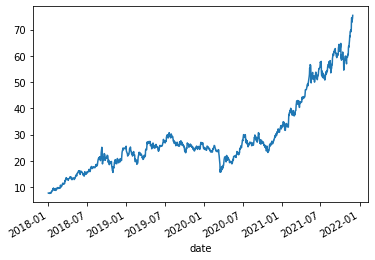

In [10]:
predictors['carbon_price'].plot()

## Keyword features

In [11]:
tf_idf = pd.read_csv( f'{methodology}_{data_source}_{glossary_source}_{version}keywords.csv',
                     index_col=0, parse_dates=True)
tf_idf.index.name = 'date'
tf_idf = tf_idf.rename(columns = {'0': 'tf_idf'})
tf_idf = tf_idf.loc[(tf_idf.index >= start_date) & (tf_idf.index <= end_date)]
tf_idf.head()

,tf_idf
date,
2018-01-01,1.581951
2018-01-02,0.790976
2018-01-03,0.000000
2018-01-04,1.846705
2018-01-05,1.900061


In [12]:
tf_idf.tail()

,tf_idf
date,
2021-11-26,1.789076
2021-11-27,1.846705
2021-11-28,0.000000
2021-11-29,1.900061
2021-11-30,1.158758


# Data preprocessing

## Dependant variable and control variables

In [13]:
predictors = predictors.groupby('date').mean()
control_variables = predictors[control_var_names]

Y = predictors[ 'carbon_price' ]

In [14]:
d_control_variables = np.log( control_variables.iloc[ 1:, : ].reset_index( drop = True) ) - \
                      np.log( control_variables.iloc[ :-1, : ].reset_index( drop = True ) )
d_control_variables.index = control_variables.iloc[ 1:, : ].index
d_Y = np.log( Y.iloc[ 1: ].reset_index( drop = True) ) - np.log( Y.iloc[ :-1 ].reset_index( drop = True ) )
d_Y.index = Y.iloc[ 1: ].index

In [15]:
d_control_variables.head()

,oil_price,gas_price,stock_price,energy_price,coal_price
date,,,,,
2018-01-03,0.018898,-0.010187,0.004804,-0.003530,-0.002071
2018-01-04,0.003385,-0.008262,0.008828,-0.001934,-0.003115
2018-01-05,-0.006633,-0.024826,0.009279,0.009001,0.001040
2018-01-08,0.002363,0.003396,0.002664,0.019447,0.002076
2018-01-09,0.015227,0.024743,0.004258,0.001850,-0.003635


In [16]:
d_control_variables.tail()

,oil_price,gas_price,stock_price,energy_price,coal_price
date,,,,,
2021-11-24,-0.000729,0.027218,0.000918,0.008023,-0.002670
2021-11-25,-0.000365,-0.007292,0.004223,0.041014,-0.010753
2021-11-26,-0.122782,-0.050829,-0.037371,-0.007483,0.000000
2021-11-29,0.009852,0.060964,0.006851,-0.003299,-0.153025
2021-11-30,-0.039864,0.009571,-0.009202,0.002550,-0.133756


## Keyword features

In [17]:
# FIX MISSING DATES: TO-DO
tf_idf = tf_idf.reindex(d_Y.index)

In [18]:
tf_idf

,tf_idf
date,
2018-01-03,0.000000
2018-01-04,1.846705
2018-01-05,1.900061
2018-01-08,2.495250
2018-01-09,1.158758
...,...
2021-11-24,0.790976
2021-11-25,1.846705
2021-11-26,1.789076


# Out-of-sample prediction

In [19]:
lags = range(1, 6)
model_types = ['ols', 'elasticnet']
test_windows = [50, 75, 100]
specifications = ['only_tf_idf', 'control', 'full']

In [20]:
%%time
forecast_results = {}
for test_window in test_windows:
    forecast_results[test_window] = {}
    for specification in specifications:
        forecast_results[test_window][specification] = {}
        for model_type in model_types:
            results_df = pd.DataFrame(index = lags, columns = ['RMSE', 'MAE'])
            for lag in lags:
                results = robustness_check_workflow(tf_idf, d_Y, d_control_variables,
                                                    lag, test_window, model_type, specification)
                results_df.loc[lag, :] = results
            forecast_results[test_window][specification][model_type] = results_df

CPU times: user 40.4 s, sys: 26.4 s, total: 1min 6s
Wall time: 39 s


In [21]:
summary_df = pd.DataFrame()

for test_window, data1 in forecast_results.items():
    for spec, data2 in data1.items():
        for model_type, data3 in data2.items():
            sub_df = copy.deepcopy(data3)
            sub_df.insert(0, 'Test window', test_window)
            sub_df.insert(1, 'Specification', spec)
            sub_df.insert(2, 'Model', model_type)
            sub_df.insert(3, 'Lags', [1, 2, 3, 4, 5])
            summary_df = pd.concat([summary_df, sub_df], axis = 0)

summary_df.to_csv('FINAL_clean_results/clean_summary_results.csv', index = False)

In [32]:
summary_df['RMSE'] = pd.to_numeric(summary_df['RMSE'])

In [42]:
# Find the min over the lags
indx = summary_df.groupby(['Test window', 'Model', 'Specification'])['RMSE'].idxmin()
indx # These are the best lags for each model type!

# A "best model example" specification shown below
# test window 100, OLS, Full, 1 lag

Test window  Model       Specification
50           elasticnet  control          3
                         full             3
                         only_tf_idf      5
             ols         control          1
                         full             1
                         only_tf_idf      3
75           elasticnet  control          3
                         full             3
                         only_tf_idf      2
             ols         control          1
                         full             1
                         only_tf_idf      4
100          elasticnet  control          3
                         full             3
                         only_tf_idf      1
             ols         control          1
                         full             1
                         only_tf_idf      4
Name: RMSE, dtype: int64

In [22]:
summary_df.groupby(['Test window', 'Model', 'Specification']).min().loc[:, ['RMSE', 'MAE']]*1000

RMSE        MAE
Test window Model      Specification                     
50          elasticnet control        0.743845  20.251865
                       full           0.740260  20.147000
                       only_tf_idf    0.786747  20.504182
            ols        control        0.690118  18.980094
                       full           0.689776  18.910325
                       only_tf_idf    0.765714  20.228913
75          elasticnet control        0.626465  18.002385
                       full           0.624024  17.889475
                       only_tf_idf    0.658871  18.271164
            ols        control        0.604362  17.277905
                       full           0.603626  17.186000
                       only_tf_idf    0.643618  18.120852
100         elasticnet control        0.557490  17.347859
                       full           0.556670  17.298305
                       only_tf_idf    0.587729  17.487962
            ols        control        0.541124  16.670493
                       full           0.541078  16.577820
                       only_tf_idf    0.578014  17.396187

In [23]:
summary_df.iloc[:20]

,Test window,Specification,Model,Lags,RMSE,MAE
1,50,only_tf_idf,ols,1,0.000775,0.020302
2,50,only_tf_idf,ols,2,0.00077,0.020229
3,50,only_tf_idf,ols,3,0.000766,0.020255
4,50,only_tf_idf,ols,4,0.000767,0.020274
5,50,only_tf_idf,ols,5,0.000775,0.020423
1,50,only_tf_idf,elasticnet,1,0.000794,0.020752
2,50,only_tf_idf,elasticnet,2,0.000788,0.020572
3,50,only_tf_idf,elasticnet,3,0.000787,0.020532
4,50,only_tf_idf,elasticnet,4,0.000787,0.020514
5,50,only_tf_idf,elasticnet,5,0.000787,0.020504


# Code testing (Model investigation / Export predictions)

In [ ]:
print(tf_idf.shape)
print(tf_idf.head())

(1010, 1)
              tf_idf
date                
2018-01-03  0.000000
2018-01-04  1.846705
2018-01-05  1.900061
2018-01-08  2.495250
2018-01-09  1.158758


In [ ]:
X = copy.deepcopy(tf_idf)
nr_lags = 3
test_window = 50 
model_type = 'ols'
specification = 'full'
elastic_net_cv = 10 #TimeSeriesSplit(n_splits=10) #10


if specification is 'full':
    X_lags = keyword_features_preprocessing(X, d_Y, d_control_variables,
                                            nr_lags)
if specification is 'only_tf_idf':
    X_lags = keyword_features_preprocessing(X, d_Y, None,
                                            nr_lags)
if specification is 'control':
    X_lags = control_var_preprocessing(d_Y, d_control_variables, nr_lags)

    
# Train-test split
d_Y_train, d_Y_test = train_test_split(d_Y, test_window)
X_train, X_test = train_test_split(X_lags, test_window)

X_test.fillna(0, inplace=True)
X_train.fillna(0, inplace=True)

# Model training
if model_type == 'elasticnet':
    model = ElasticNetCV(cv=elastic_net_cv, random_state=0, fit_intercept=False,
                        l1_ratio=[0, 0.01, .1, .5, .7, .9, .95, .99, 1],
                        alphas=[0, 0.001, 0.003, 0.005, 0.007, 0.009, 0.0095, 0.01])
    model.fit(X_train, d_Y_train)

elif model_type == 'ols':
    model_pre = sm.OLS(d_Y_train, X_train, missing = 'drop', hasconst=True)
    model = model_pre.fit()


# Validation
y_pred = model.predict(X_test)

print([mean_squared_error(d_Y_test, y_pred, squared=True), mean_absolute_error(d_Y_test, y_pred)])

[0.0007882073835677586, 0.021369066767109667]


In [ ]:
# Export predictions
pd.DataFrame({'prediction': y_pred,
              'true value': d_Y_test}).to_csv(f'forecasts/test_pred_{specification}_{model_type}_{nr_lags}lags_{test_window}test_window.csv')

In [ ]:
# X_lags

In [ ]:
# Only TF-IDF, const + 3 lag
print(model.coef_)
print(sum(model.coef_==0))

AttributeError: ignored

In [ ]:
# Full, const + 3 lag
print(model.coef_)

AttributeError: ignored

In [ ]:
# Check hyperparameters chosen my CV
print(model.l1_ratio_)
print(model.alpha_)
print(model.dual_gap_) # Essentially zero

AttributeError: ignored

In [ ]:
# Compare train vs test error
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

print(f"Train MAE: {round(mean_absolute_error(d_Y_train, y_pred_train), 4)}")
print(f"Test MAE: {round(mean_absolute_error(d_Y_test, y_pred_test), 4)}")

Train MAE: 0.0215
Test MAE: 0.0214


In [ ]:
# Train-test performance difference is substantially larger for ElasticNet than for OLS